<a href="https://colab.research.google.com/github/BhaktiGajipara/LLM/blob/main/transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:51<00:00, 22.7MB/s]
100% 1.06G/1.06G [00:51<00:00, 22.0MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Define the paths to the ZIP files
zip_path1 = '/content/drive/My Drive/training_data.zip'
zip_path2 = '/content/drive/My Drive/testing_data.zip'

# Define the extraction paths
extract_path1 = '/content/training_data'
extract_path2 = '/content/testing_data'

# Create the extraction directories if they don't exist
os.makedirs(extract_path1, exist_ok=True)
os.makedirs(extract_path2, exist_ok=True)

# Unzip the first file
with zipfile.ZipFile(zip_path1, 'r') as zip_ref:
    zip_ref.extractall(extract_path1)

# Unzip the second file
with zipfile.ZipFile(zip_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_path2)

print('Unzipping of both files complete!')

Unzipping of both files complete!


In [ ]:
import tensorflow
from tensorflow import keras
from keras.src.utils import image_dataset
from keras import Sequential
from keras.layers import Flatten,Dense
from keras.applications.vgg16 import VGG16

In [ ]:
conv_base = VGG16(weights = "imagenet",
                  include_top = False,
                  input_shape = (150,150,3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation = "relu"))
model.add(Dense(1,activation ="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# generator
train_ds = keras.utils.image_dataset_from_directory(
    directory = "/content/train",
    labels = "inferred",
    label_mode = "int",
    batch_size = 32,
    image_size = (150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = "/content/test",
    labels = "inferred",
    label_mode = "int",
    batch_size = 32,
    image_size = (150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [ ]:
# Normalize

def process(image,label1):
  image = tensorflow.cast(image/255. ,tensorflow.float32)
  return image,label1

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model.fit(train_ds,epochs = 10, validation_data = validation_ds)

Epoch 1/10
625/625 [==============================] - 236s 372ms/step - loss: 21488370.0000 - accuracy: 0.6130 - val_loss: 0.6249 - val_accuracy: 0.6506
Epoch 2/10
625/625 [==============================] - 151s 241ms/step - loss: 0.5565 - accuracy: 0.7181 - val_loss: 0.5206 - val_accuracy: 0.7410
Epoch 3/10
625/625 [==============================] - 152s 243ms/step - loss: 0.5043 - accuracy: 0.7552 - val_loss: 0.4650 - val_accuracy: 0.7796
Epoch 4/10
625/625 [==============================] - 144s 230ms/step - loss: 0.4618 - accuracy: 0.7847 - val_loss: 0.4869 - val_accuracy: 0.7800
Epoch 5/10
625/625 [==============================] - 145s 231ms/step - loss: 0.4043 - accuracy: 0.8169 - val_loss: 0.4160 - val_accuracy: 0.8048
Epoch 6/10
625/625 [==============================] - 154s 247ms/step - loss: 0.3590 - accuracy: 0.8419 - val_loss: 0.3394 - val_accuracy: 0.8546
Epoch 7/10
625/625 [==============================] - 155s 247ms/step - loss: 0.3198 - accuracy: 0.8632 - val_loss: 0

In [ ]:
model.save('transfer_learning_feature_extraction.keras')

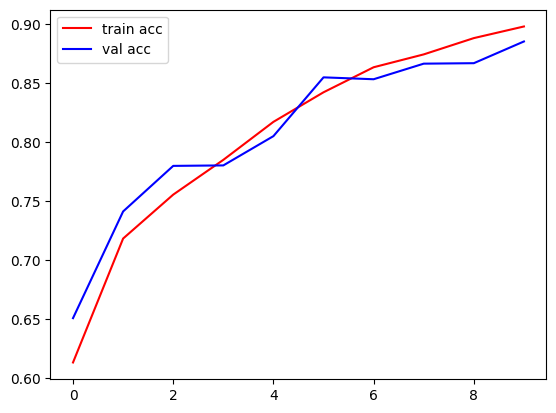

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color = "red", label='train acc')
plt.plot(history.history['val_accuracy'],color = "blue" , label='val acc')
plt.legend()
plt.show()